In [1]:
import torch
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader

In [2]:
from importlib import reload
# import [module]
# importlib.reload([module])

In [3]:
import numpy as np
import matplotlib.pyplot as plt
def show(x):
    plt.imshow(x,'gray')
    plt.show()

In [4]:
from custom.models import conv_SVM, seg_net
from custom.utils import get_weight_c
from custom.datasets import nuclei_dataset, nuclei_data
from custom.loss import weighted_bce_loss_with_logits

/root/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.16) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [5]:
dat = nuclei_data(path='../data/stage1_train/')
# dat1 = nuclei_data(path='../data/stage1_train/', label=1)
# dat2 = nuclei_data(path='../data/stage1_train/', label=2)

train_loader = DataLoader(nuclei_dataset(dat, mode='train'),batch_size=16, shuffle=True)
full_loader = DataLoader(nuclei_dataset(dat, mode='full'),batch_size=16, shuffle=True)
test_loader = DataLoader(nuclei_dataset(dat, mode='eval'), batch_size=8)

# train_loader1 = DataLoader(nuclei_dataset(dat1),batch_size=8, shuffle=True)
# test_loader1 = DataLoader(nuclei_dataset(dat1, train=False), batch_size=8)

# train_loader2 = DataLoader(nuclei_dataset(dat2),batch_size=16, shuffle=True)
# test_loader2 = DataLoader(nuclei_dataset(dat2, train=False), batch_size=16)

/home/data/notebook/data/yujie/cell_segmentation/cell_detection/custom/datasets.py:141: RuntimeWarning: divide by zero encountered in double_scalars
  weights[labels==l] = total_count * 1. / nl / l_count


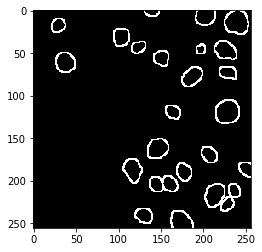

In [6]:
im, mask, dist, _ =dat[43]
show(mask)

In [7]:
model = seg_net()
# model.load_state_dict(torch.load('./models/segnet_1'))
# pretrained_filter = torch.load('./models/segnet_1')
# model = conv_SVM()

In [8]:
model.cuda()

seg_net(
  (conv_block_1): conv357_block(
    (conv3): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv5): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (conv7): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (norm): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True)
  )
  (conv_block_2): conv357_block(
    (conv3): Conv2d(192, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv5): Conv2d(192, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (conv7): Conv2d(192, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (norm): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True)
  )
  (conv_block_3): conv357_block(
    (conv3): Conv2d(96, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv5): Conv2d(96, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (conv7): Conv2d(96, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (norm): BatchNorm2d(48, eps=1e-05, m

In [9]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)

In [10]:
loss_func = weighted_bce_loss_with_logits
# loss_func = lambda x, y, z: F.hinge_embedding_loss(x, (y-.5)*2)

In [11]:
from torchvision.utils import save_image
to_cuda_var = lambda x: Variable(x.float()).cuda()
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (im, mask, dist, wt) in enumerate(train_loader):
        weight = get_weight_c(mask, factor01=(.5, .5)) + 10. * np.exp(-np.power(dist.numpy(), 2) / 25.)
        weight = weight * wt.numpy().reshape((-1, 1, 1, 1))
        weight = torch.from_numpy(weight)
        input, target, weight = to_cuda_var(im), to_cuda_var(mask), to_cuda_var(weight)
        
        optimizer.zero_grad()
        output = model(input)
        loss = loss_func(output, target, weight)
        loss.backward()
        train_loss += loss.data[0]
        optimizer.step()
        
        if batch_idx == 0:
            n = 8
            comparison = torch.cat([input[:n], output[:n]])
            save_image(comparison.data.cpu(),
                     './results/train_' + str(epoch) + '.png', nrow=n)

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

In [12]:
from torchvision.utils import save_image
to_cuda_var = lambda x: Variable(x.float()).cuda()
from torch.nn.functional import threshold
def test(epoch):
    model.eval()
    test_loss = 0
    for i, (im, mask, dist, _) in enumerate(test_loader):
        weight = get_weight_c(mask, factor01=(.5, .5)) + 10. * np.exp(-np.power(dist.numpy(), 2) / 25.)
        weight = torch.from_numpy(weight)
        input, target, weight = to_cuda_var(im), to_cuda_var(mask), to_cuda_var(weight)
        output = model(input)
        test_loss += loss_func(output, target, weight).data[0]
        label = threshold(-threshold(output, .5, 0, inplace=True), -.5, 1, inplace=True)
        if i == 0:
            n = 8
            comparison = torch.cat([input[:n], label[:n]])
            save_image(comparison.data.cpu(),
                     './results/test_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [13]:
torch.cuda.empty_cache()
epochs = 20
for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)
#


====> Epoch: 1 Average loss: 0.0429
====> Test set loss: 3.0186
====> Epoch: 2 Average loss: 0.0428
====> Test set loss: 2.9988
====> Epoch: 3 Average loss: 0.0424
====> Test set loss: 2.2721
====> Epoch: 4 Average loss: 0.0402
====> Test set loss: 3.5360
====> Epoch: 5 Average loss: 0.0409
====> Test set loss: 3.2760
====> Epoch: 6 Average loss: 0.0404
====> Test set loss: 2.7950
====> Epoch: 7 Average loss: 0.0461
====> Test set loss: 2.8140
====> Epoch: 8 Average loss: 0.0391
====> Test set loss: 2.6991
====> Epoch: 9 Average loss: 0.0374
====> Test set loss: 2.0996
====> Epoch: 10 Average loss: 0.0378
====> Test set loss: 2.6406
====> Epoch: 11 Average loss: 0.0359
====> Test set loss: 2.6296
====> Epoch: 12 Average loss: 0.0374
====> Test set loss: 2.5880
====> Epoch: 13 Average loss: 0.0358
====> Test set loss: 2.5064
====> Epoch: 14 Average loss: 0.0356
====> Test set loss: 1.9194
====> Epoch: 15 Average loss: 0.0341
====> Test set loss: 2.5104
====> Epoch: 16 Average loss: 0.03

In [14]:
torch.save(model.state_dict(), './models/segnet_1')